In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import time
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
try:
    from matplotlib_venn import venn2
except ImportError:
    import subprocess
    subprocess.check_call(["pip", "install", "matplotlib-venn"])
    from matplotlib_venn import venn2


plt.style.use('bmh')
np.random.seed(42)
print("Libraries Loaded.")

Libraries Loaded.


In [4]:
# ==========================================
# Part 1: Data Preparation 
# ==========================================

# Loading SECOM Dataset 
print("Loading SECOM Dataset")
url_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
url_labels = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

try:
    df_features = pd.read_csv(url_data, sep="\s+", header=None)
    df_labels = pd.read_csv(url_labels, sep="\s+", header=None)
    print("Data loaded successfully from UCI Repository.")
except Exception as e:
    print(f"Error loading data: {e}")

# Assign meaningful column names to track sensors later 
df_features.columns = [f"Sensor_{i}" for i in range(df_features.shape[1])]
y = df_labels.iloc[:, 0].values 

print(f"Original Feature Matrix Shape: {df_features.shape}")
print(f"Original Labels Shape: {y.shape}")

# Remove Constant Columns
print("\nRemoving Constant Columns")
selector_variance = VarianceThreshold(threshold=0)
selector_variance.fit(df_features)

kept_features_mask = selector_variance.get_support()
kept_feature_names = df_features.columns[kept_features_mask]
dropped_feature_names = df_features.columns[~kept_features_mask]

df_reduced = df_features.loc[:, kept_features_mask]

print(f"Number of features before removal: {df_features.shape[1]}")
print(f"Number of features after removal: {df_reduced.shape[1]}")
print(f"Number of constant features dropped: {len(dropped_feature_names)}")
print(f"First 5 dropped sensors: {list(dropped_feature_names[:5])}")

# Imputation 
print("\nImputing Missing Values (Median)")
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df_reduced), columns=df_reduced.columns)

print(f"Missing values after imputation: {df_imputed.isnull().sum().sum()}")

# Standardization (Z-Score) 
print("\nStandardization (Z-Score)")
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed), columns=df_imputed.columns)

print(f"Final Processed Data Shape: {df_scaled.shape}")

Loading SECOM Dataset
Data loaded successfully from UCI Repository.
Original Feature Matrix Shape: (1567, 590)
Original Labels Shape: (1567,)

Removing Constant Columns
Number of features before removal: 590
Number of features after removal: 474
Number of constant features dropped: 116
First 5 dropped sensors: ['Sensor_5', 'Sensor_13', 'Sensor_42', 'Sensor_49', 'Sensor_52']

Imputing Missing Values (Median)
Missing values after imputation: 0

Standardization (Z-Score)
Final Processed Data Shape: (1567, 474)


In [6]:
# ==========================================
# Part 2: Classic Feature Selection Methods (Filter vs. Wrapper)
# ==========================================

N_FEATURES = 20  

# Filter Method (Mutual Information) 
print("\nFilter Method (Mutual Information)")
start_time_mi = time.time()

selector_mi = SelectKBest(score_func=mutual_info_classif, k=N_FEATURES)
selector_mi.fit(df_scaled, y)

mi_time = time.time() - start_time_mi

# Extract selected feature names and their scores
mi_support = selector_mi.get_support()
mi_selected_features = df_scaled.columns[mi_support]
mi_scores = selector_mi.scores_[mi_support]

df_mi_results = pd.DataFrame({'Feature': mi_selected_features, 'MI_Score': mi_scores})
df_mi_results = df_mi_results.sort_values(by='MI_Score', ascending=False).reset_index(drop=True)

print(f"Mutual Information Selection Time: {mi_time:.4f} seconds")
print("Top 20 Features selected by MI:")
print(df_mi_results)

# Wrapper Method (RFE with RandomForest)
print("\nWrapper Method (RFE with RandomForest)")
start_time_rfe = time.time()

# RFE with RandomForestClassifier
rf_estimator = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
selector_rfe = RFE(estimator=rf_estimator, n_features_to_select=N_FEATURES, step=1)
selector_rfe.fit(df_scaled, y)

rfe_time = time.time() - start_time_rfe

# Extract selected feature names
rfe_support = selector_rfe.get_support()
rfe_selected_features = df_scaled.columns[rfe_support]
rfe_importances = selector_rfe.estimator_.feature_importances_

df_rfe_results = pd.DataFrame({'Feature': rfe_selected_features, 'RF_Importance': rfe_importances})
df_rfe_results = df_rfe_results.sort_values(by='RF_Importance', ascending=False).reset_index(drop=True)

print(f"RFE Execution Time: {rfe_time:.4f} seconds")
print("Top 20 Features selected by RFE:")
print(df_rfe_results)

# Compare Overlap
common_features = set(mi_selected_features) & set(rfe_selected_features)
print(f"\nNumber of common features between MI and RFE: {len(common_features)}")
print(f"Common Features: {common_features}")


Filter Method (Mutual Information)
Mutual Information Selection Time: 3.0131 seconds
Top 20 Features selected by MI:
       Feature  MI_Score
0   Sensor_577  0.029658
1   Sensor_331  0.028110
2   Sensor_477  0.026916
3   Sensor_128  0.025471
4    Sensor_41  0.024929
5    Sensor_40  0.024828
6   Sensor_571  0.024344
7    Sensor_56  0.024196
8   Sensor_411  0.023689
9   Sensor_130  0.022934
10  Sensor_541  0.022690
11  Sensor_573  0.022231
12  Sensor_570  0.021920
13  Sensor_539  0.021366
14  Sensor_576  0.021059
15  Sensor_416  0.021029
16  Sensor_309  0.020782
17   Sensor_65  0.020774
18  Sensor_122  0.020680
19  Sensor_134  0.020630

Wrapper Method (RFE with RandomForest)
RFE Execution Time: 290.9748 seconds
Top 20 Features selected by RFE:
       Feature  RF_Importance
0    Sensor_59       0.066658
1    Sensor_64       0.060610
2    Sensor_65       0.052337
3   Sensor_132       0.051625
4   Sensor_348       0.050965
5   Sensor_539       0.050875
6   Sensor_426       0.050483
7    Se

In [7]:
# ==========================================
# Part 3: Algebraic Method (SVD Feature Ranking)
# ==========================================

print("\nAlgebraic Method (SVD Feature Ranking)")
start_time_svd = time.time()

# Decomposition  U: (1567, 474), S: (474,), Vt: (474, 474)
U, S, Vt = np.linalg.svd(df_scaled.values, full_matrices=False)

# Scoring Function Implementation : Score_j = sum_{i=1 to k} (sigma_i^2 * |V_ij|)
weights = S ** 2

abs_Vt = np.abs(Vt)
svd_scores = np.dot(weights, abs_Vt)
svd_time = time.time() - start_time_svd

# Selection
df_svd_results = pd.DataFrame({
    'Feature': df_scaled.columns,
    'SVD_Score': svd_scores
})

# Sort and select top 20
df_svd_results = df_svd_results.sort_values(by='SVD_Score', ascending=False).reset_index(drop=True)
svd_selected_features = df_svd_results.head(20)

print(f"SVD Calculation & Ranking Time: {svd_time:.4f} seconds")
print("Top 20 Features selected by SVD:")
print(svd_selected_features)

print("\nFirst 5 Singular Values (Sigmas):", S[:5])
print("Last 5 Singular Values (Sigmas):", S[-5:])
print("First 5 Weights (Sigma^2):", weights[:5])


Algebraic Method (SVD Feature Ranking)
SVD Calculation & Ranking Time: 0.3093 seconds
Top 20 Features selected by SVD:
       Feature     SVD_Score
0   Sensor_441  27715.444159
1   Sensor_170  27472.407333
2    Sensor_72  27422.350208
3    Sensor_29  27356.489279
4   Sensor_305  27110.386678
5   Sensor_473  27097.061490
6   Sensor_129  26991.300991
7    Sensor_73  26991.066035
8    Sensor_59  26949.159982
9   Sensor_303  26847.165198
10  Sensor_476  26819.543857
11  Sensor_167  26816.914537
12  Sensor_169  26802.889794
13  Sensor_452  26799.180487
14   Sensor_65  26787.418276
15  Sensor_168  26784.488621
16  Sensor_440  26762.964685
17  Sensor_302  26720.855331
18  Sensor_304  26695.346849
19  Sensor_180  26562.197805

First 5 Singular Values (Sigmas): [203.18719336 164.47398762 144.81841994 137.46760859 127.55632808]
Last 5 Singular Values (Sigmas): [1.58557883e-14 1.32660324e-14 1.32660324e-14 1.32660324e-14
 1.32660324e-14]
First 5 Weights (Sigma^2): [41285.03554404 27051.6926038  

--- Detailed Loadings Matrix Analysis ---


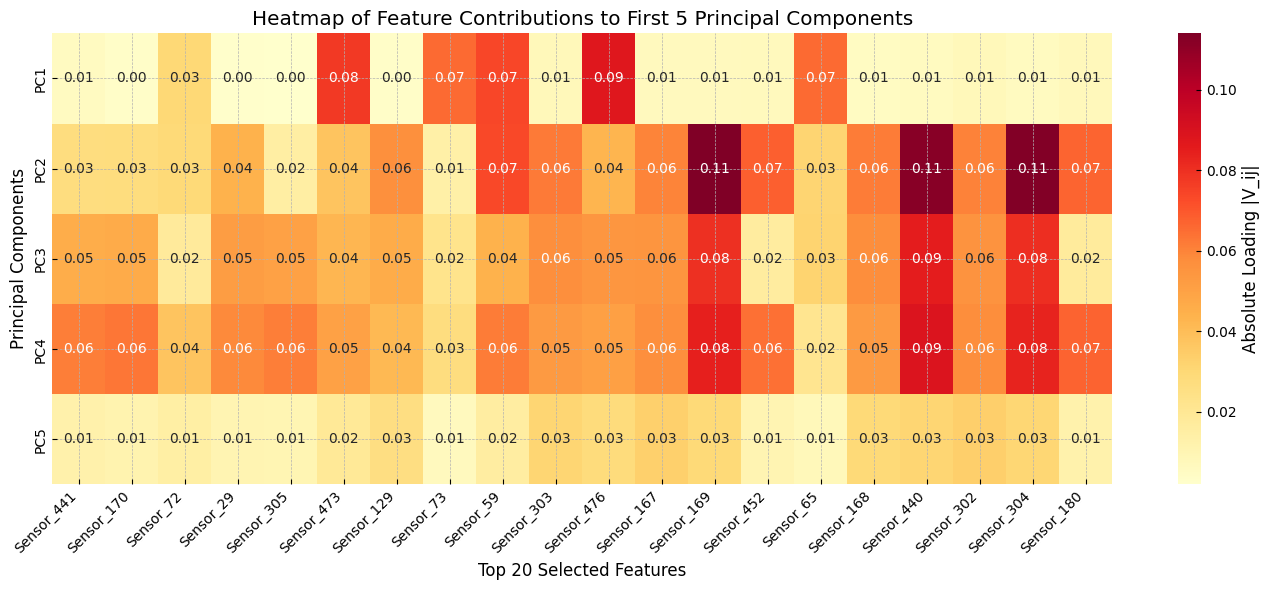

Analysis: Darker/Redder cells indicate which Component is most influenced by a specific Sensor.


In [8]:
# ==========================================
# Detailed Loadings Matrix Analysis (Heatmap)
# ==========================================
print("--- Detailed Loadings Matrix Analysis ---")


top_20_features = svd_selected_features['Feature'].values
top_20_indices = [df_scaled.columns.get_loc(f) for f in top_20_features]

n_components = 5
loadings_subset = Vt[:n_components, top_20_indices]

# Plot Heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(np.abs(loadings_subset), 
            xticklabels=top_20_features, 
            yticklabels=[f'PC{i+1}' for i in range(n_components)],
            cmap='YlOrRd', annot=True, fmt='.2f', cbar_kws={'label': 'Absolute Loading |V_ij|'})

plt.title(f'Heatmap of Feature Contributions to First {n_components} Principal Components')
plt.xlabel('Top 20 Selected Features')
plt.ylabel('Principal Components')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("Analysis: Darker/Redder cells indicate which Component is most influenced by a specific Sensor.")


Geometric Analysis (Loadings Plot)


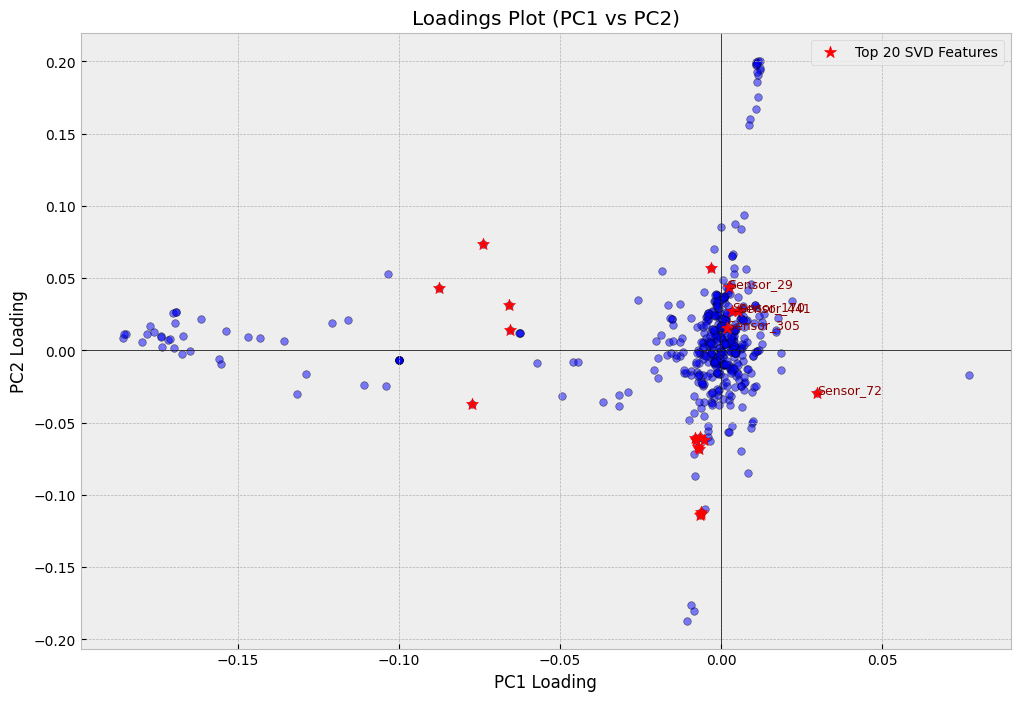

Stability Test (5% Noise Injection)
Added 5% Gaussian noise to the dataset.
Re-running SVD on noisy data...
Re-running RFE on noisy data
RFE on noisy data finished in 363.95 seconds.
Stability Results:
SVD Stability: 90.0% (18/20 preserved)
RFE Stability: 60.0% (12/20 preserved)
SVD Changed Features: {'Sensor_180', 'Sensor_452'}
RFE Changed Features: {'Sensor_77', 'Sensor_16', 'Sensor_523', 'Sensor_426', 'Sensor_40', 'Sensor_152', 'Sensor_475', 'Sensor_25'}


In [9]:
# ==========================================
# Part 4: Geometric Analysis & Stability Test
# ==========================================

print("Geometric Analysis (Loadings Plot)")

# Plotting the Loadings of the first two principal components. Vt row 0 is PC1, Vt row 1 is PC2. Each column of Vt is a feature

plt.figure(figsize=(12, 8))
# Scatter plot of all features
plt.scatter(Vt[0, :], Vt[1, :], alpha=0.5, c='blue', edgecolors='k', s=30)

# Highlight the top features selected by SVD
svd_top20_indices = [df_scaled.columns.get_loc(f) for f in svd_selected_features['Feature']]
plt.scatter(Vt[0, svd_top20_indices], Vt[1, svd_top20_indices], c='red', s=80, marker='*', label='Top 20 SVD Features')

plt.title('Loadings Plot (PC1 vs PC2)')
plt.xlabel('PC1 Loading')
plt.ylabel('PC2 Loading')
plt.grid(True)
plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)

# Annotate a few top features
for idx in svd_top20_indices[:5]:  # Label top 5
    feature_name = df_scaled.columns[idx]
    plt.text(Vt[0, idx], Vt[1, idx], feature_name, fontsize=9, color='darkred')

plt.show()

print("Stability Test (5% Noise Injection)")

# 1. Add 5% random noise
noise_level = 0.05
noise = np.random.normal(0, noise_level, df_scaled.shape)
df_noisy = df_scaled + noise
print("Added 5% Gaussian noise to the dataset.")

# 2. Re-run SVD on noisy data
print("Re-running SVD on noisy data...")
U_n, S_n, Vt_n = np.linalg.svd(df_noisy.values, full_matrices=False)
weights_n = S_n ** 2
svd_scores_n = np.dot(weights_n, np.abs(Vt_n))

df_svd_noisy = pd.DataFrame({'Feature': df_noisy.columns, 'SVD_Score': svd_scores_n})
svd_selected_noisy = df_svd_noisy.sort_values(by='SVD_Score', ascending=False).head(20)['Feature'].values

# 3. Re-run RFE on noisy data
print("Re-running RFE on noisy data")
start_time_rfe_noisy = time.time()
selector_rfe_noisy = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1), 
                         n_features_to_select=20, step=1)
selector_rfe_noisy.fit(df_noisy, y)
rfe_selected_noisy = df_noisy.columns[selector_rfe_noisy.get_support()].values
print(f"RFE on noisy data finished in {time.time() - start_time_rfe_noisy:.2f} seconds.")

# 4. Compare results
original_svd_set = set(svd_selected_features['Feature'])
noisy_svd_set = set(svd_selected_noisy)
common_svd = original_svd_set.intersection(noisy_svd_set)
svd_stability = len(common_svd) / 20.0 * 100

original_rfe_set = set(rfe_selected_features)
noisy_rfe_set = set(rfe_selected_noisy)
common_rfe = original_rfe_set.intersection(noisy_rfe_set)
rfe_stability = len(common_rfe) / 20.0 * 100

print(f"Stability Results:")
print(f"SVD Stability: {svd_stability:.1f}% ({len(common_svd)}/20 preserved)")
print(f"RFE Stability: {rfe_stability:.1f}% ({len(common_rfe)}/20 preserved)")

print(f"SVD Changed Features: {original_svd_set - noisy_svd_set}")
print(f"RFE Changed Features: {original_rfe_set - noisy_rfe_set}")


Final Comparison & Classification
Training Logistic Regression on subsets
Comparison Table:
  Method  Accuracy  F1-Score    Time (s)
0     MI  0.668790  0.752167    3.013096
1    RFE  0.772824  0.827554  290.974829
2    SVD  0.715499  0.786603    0.309265
Overlap Analysis (Venn Diagram)


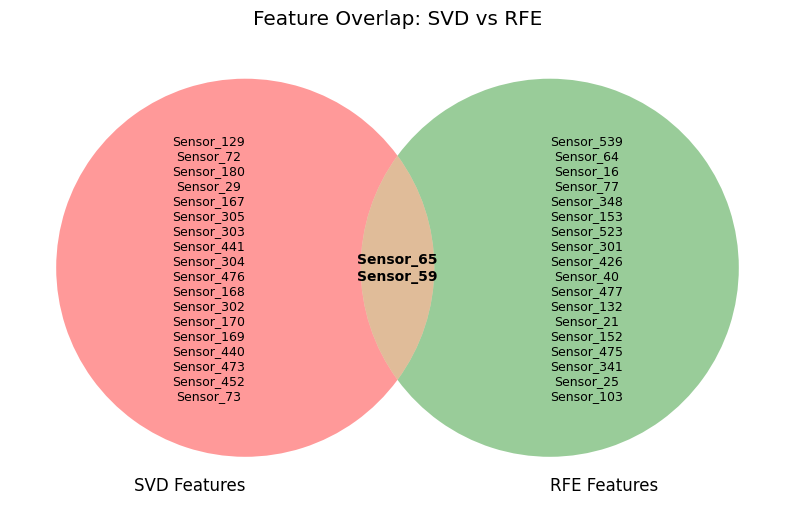

------------------------------
Features unique to SVD: ['Sensor_129', 'Sensor_72', 'Sensor_180', 'Sensor_29', 'Sensor_167', 'Sensor_305', 'Sensor_303', 'Sensor_441', 'Sensor_304', 'Sensor_476', 'Sensor_168', 'Sensor_302', 'Sensor_170', 'Sensor_169', 'Sensor_440', 'Sensor_473', 'Sensor_452', 'Sensor_73']
Features unique to RFE: ['Sensor_539', 'Sensor_64', 'Sensor_16', 'Sensor_77', 'Sensor_348', 'Sensor_153', 'Sensor_523', 'Sensor_301', 'Sensor_426', 'Sensor_40', 'Sensor_477', 'Sensor_132', 'Sensor_21', 'Sensor_152', 'Sensor_475', 'Sensor_341', 'Sensor_25', 'Sensor_103']
Common Features: ['Sensor_65', 'Sensor_59']


In [10]:
# ==========================================
# Part 5: Final Comparison & Evaluation
# ==========================================
print("Final Comparison & Classification")

# Prepare Datasets
features_mi = mi_selected_features
features_rfe = rfe_selected_features
features_svd = svd_selected_features['Feature'].values

datasets = {
    'MI': df_scaled[features_mi],
    'RFE': df_scaled[features_rfe],
    'SVD': df_scaled[features_svd]
}

results = []

# Train & Evaluate Logistic Regression for each subset
print("Training Logistic Regression on subsets")
for method_name, X_subset in datasets.items():
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42, stratify=y)
    
    # Train Model
    clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Retrieve timing 
    if method_name == 'MI': execution_time = mi_time
    elif method_name == 'RFE': execution_time = rfe_time
    elif method_name == 'SVD': execution_time = svd_time
    
    results.append({
        'Method': method_name,
        'Accuracy': acc,
        'F1-Score': f1,
        'Time (s)': execution_time
    })

# Display Comparison Table
df_results = pd.DataFrame(results)
print("Comparison Table:")
print(df_results)


# Venn Diagram (SVD vs RFE)
print("Overlap Analysis (Venn Diagram)")

set_svd = set(features_svd)
set_rfe = set(features_rfe)

only_svd = set_svd - set_rfe      
only_rfe = set_rfe - set_svd      
intersection = set_svd & set_rfe  

plt.figure(figsize=(10, 8)) 
v = venn2([set_svd, set_rfe], set_labels=('SVD Features', 'RFE Features'))

def format_features(feature_set):
    return "\n".join(list(feature_set))

# SVD features
if v.get_label_by_id('10'):
    v.get_label_by_id('10').set_text(format_features(only_svd))
    v.get_label_by_id('10').set_fontsize(9)  

# RFE features
if v.get_label_by_id('01'):
    v.get_label_by_id('01').set_text(format_features(only_rfe))
    v.get_label_by_id('01').set_fontsize(9)

# intersection
if v.get_label_by_id('11'):
    v.get_label_by_id('11').set_text(format_features(intersection))
    v.get_label_by_id('11').set_fontsize(10)
    v.get_label_by_id('11').set_fontweight('bold') 

plt.title('Feature Overlap: SVD vs RFE')
plt.show()

# Calculate intersection explicitely for report
print("-" * 30)
print(f"Features unique to SVD: {list(only_svd)}")
print(f"Features unique to RFE: {list(only_rfe)}")
print(f"Common Features: {list(intersection)}")